In [19]:
import os, sys
import io
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix

print(tf.keras.__version__)
# for subdir in sorted(os.listdir()):
#     print(subdir)

2.8.0


In [2]:
#CREATE THE EFFICIENTNET MODEL

def createEfficientNet(input_shape, numb, trainable):
    
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        print("Not connected to a TPU runtime. Using CPU/GPU strategy")
        strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():   # loading pretrained conv base model
    
        
        conv_base = EfficientNetB7(weights="imagenet", include_top=False, input_shape=input_shape)    

        #for layer in conv_base.layers:
        #    layer.trainable = trainable        
        conv_base.trainable = trainable

        dropout_rate = 0.2
        model = models.Sequential()

        model.add(conv_base)
        model.add(layers.GlobalMaxPooling2D(name="gap"))
        #model.add(layers.Flatten(name="flatten"))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate, name="dropout_out"))
        #model.add(layers.Dense(256, activation='relu', name="fc1"))
        model.add(layers.Dense(number_of_classes, activation="sigmoid", name="fc_out"))

        model.compile(
            #optimizer=optimizers.RMSprop(lr=2e-5),a
            optimizer=optimizers.Adam(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["acc"],
        )
        #model.compile(
        #    optimizer="adam", 
        #    loss="categorical_crossentropy", 
        #    metrics=["accuracy"]
        #)
        model.summary()
        
        
    return model

In [3]:
#LOAD IN THE DATA

def createDataGenerators(data_dir, image_size, batch_size, seed = 1):
    
    # Train data genrator
    # Settings from AMT
    train_datagen = ImageDataGenerator(
        rotation_range = 180,
        horizontal_flip = True,
        vertical_flip = True,
        zoom_range=0.3,
        validation_split=0.2,
        brightness_range=[0.9, 1.1]
    )

    # Note that the validation data should not be augmented!
    test_datagen = ImageDataGenerator(
        validation_split=0.2
    )
    
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        data_dir,
        # All images will be resized to target height and width.
        target_size=(image_size, image_size),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=seed
    )
    
    validation_generator = test_datagen.flow_from_directory(
        data_dir,
        # All images will be resized to target height and width.
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode="categorical",
        subset='validation',
        shuffle=False,
        seed=seed
    )
    
    return train_generator, validation_generator

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 gap (GlobalMaxPooling2D)    (None, 2560)              0         
                                                                 
 dropout_out (Dropout)       (None, 2560)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 5122      
                                                                 
Total params: 64,102,809
Trainable params: 5,122
Non-trainable params: 64,097,687
_________________________________________________________________
Found 488 ima

c:\users\dbior\anaconda3\envs\bs\lib\site-packages\ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Confusion Matrix
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.97      0.93      0.95        30

    accuracy                           0.98       121
   macro avg       0.97      0.96      0.97       121
weighted avg       0.98      0.98      0.98       121

F1-score: 0.975064239607421


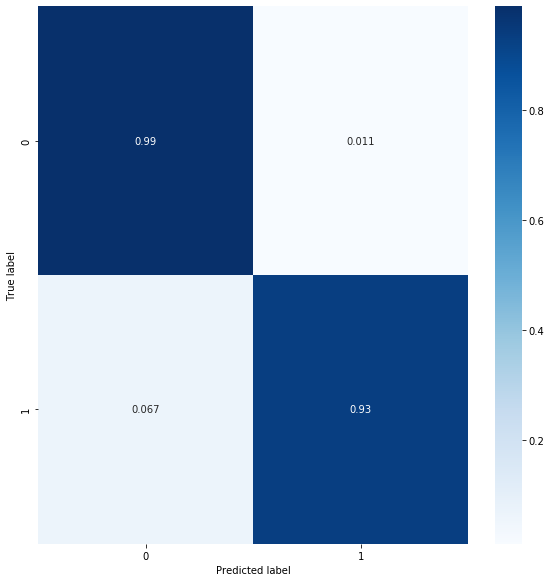

<Figure size 432x288 with 0 Axes>

In [11]:
#RUN THE CODE, BROTHER!

if __name__=='__main__': 
    
    data_dir = 'data/train'
    
    # Directory for saving h5 models for each run
    models_dir = './models_save'   
    log_dir = './hparam_tuning'

    number_of_classes = 2
    batch_size = 32
    epochs = 58 # 38 EfficientNetB0+others, 27 MobileNetV2, 25 InceptionV3, 35 ResNet50V2, 25 ResNet50V2 with imagenet
    image_size = 224 # MobileNetV2, EfficientNetB0, ResNet50V2

    NUM_DATA = 609
    TEST_SPLIT = 0.2
    NUM_TRAIN = NUM_DATA*(1.0 - TEST_SPLIT)
    NUM_TEST = NUM_DATA*TEST_SPLIT

    input_shape= (image_size, image_size, 3)

    model = createEfficientNet(input_shape, number_of_classes, False)

    train_generator, validation_generator = createDataGenerators(data_dir, image_size, batch_size)

    print("DET ER HER: " + str(train_generator.__len__()))
    
    # Extend with examed hyperparameters
    HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32]))
    HP_IMG_SIZE = hp.HParam('image_size', hp.Discrete([224]))

    hparams = {
            HP_BATCH_SIZE: batch_size,
            HP_IMG_SIZE: image_size
            }
    
    history = model.fit(
        train_generator,
        steps_per_epoch= NUM_TRAIN // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=NUM_TEST // batch_size,
        verbose=1,
        callbacks=[
                   tf.keras.callbacks.TensorBoard(log_dir),
                   hp.KerasCallback(log_dir, hparams),
                   ],
    )
    
    print('Model predict')
    Y_pred = model.predict_generator(validation_generator) #, 173//batch_size+1
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(classification_report(validation_generator.classes, y_pred))
    report = classification_report(validation_generator.classes, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    print('F1-score:', f1_score)


    model.save(models_dir + '/' +  'EfficientNetB7.h5')

    conf = confusion_matrix(validation_generator.classes, y_pred, normalize='true')
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(conf, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confmatrix.png')
    plt.show()
    plt.close(figure)